In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Load the cleaned dataset
file_path = (r"C:\Users\dinne\Diabetic-Readmissions-\Data\Processed\cleaned_diabetic_data.csv")
df = pd.read_csv(file_path)

# Sanity check
print(f"Final shape after cleaning: {df.shape}")
print(f"Number of missing values: {df.isnull().sum().sum()}")
print(df.columns)

Final shape after cleaning: (101766, 71)
Number of missing values: 0
Index(['age', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Other', 'gender_Male', 'gender_Unknown',
       'max_glu_serum_>300', 'max_glu_serum_Norm', 'A1Cresult_>8',
       'A1Cresult_Norm', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_No', 'nateglinide_Steady', 'nateglinide_Up',
       'chlorpropamide_No', 'chlorpropamide_Steady', 'chlorpropamide_Up',
       'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up',
       'acetohexamide_Steady', 'glipizide_No', 'glipizide_Steady',
       'glipizide_Up', '

In [9]:
# Split features and target
X = df.drop('readmitted', axis=1)
y = df['readmitted']


print(f"✓ Features: {X.shape[1]}, Samples: {X.shape[0]}")
print(f"✓ Readmission rate: {(y.mean() * 100):.2f}%")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"✓ Training set: {X_train.shape[0]}, Test set: {X_test.shape[0]}")

# Calculate scale_pos_weight for imbalance handling
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"✓ Scale pos weight: {scale_pos_weight:.2f}")

✓ Features: 70, Samples: 101766
✓ Readmission rate: 11.16%
✓ Training set: 71236, Test set: 30530
✓ Scale pos weight: 7.96


In [10]:
# Cell 3: XGBoost - Model Training with scale_pos_weight
print("🚀 TRAINING XGBOOST MODEL (with scale_pos_weight)...")

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create and train model with scale_pos_weight
xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight  # This handles the class imbalance
)

xgb_grid = GridSearchCV(
    xgb_model, param_grid, cv=3, scoring='roc_auc',
    n_jobs=-1, verbose=1
)

print("Starting GridSearchCV... This may take a few minutes.")
xgb_grid.fit(X_train, y_train)  # Training on original data, no resampling

print(f"✅ Training complete!")
print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")

🚀 TRAINING XGBOOST MODEL (with scale_pos_weight)...
Starting GridSearchCV... This may take a few minutes.
Fitting 3 folds for each of 48 candidates, totalling 144 fits
✅ Training complete!
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.6679


In [12]:
# Cell 4: XGBoost - Predictions and Evaluation
# Get best model
best_xgb = xgb_grid.best_estimator_

# Predictions
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Calculate metrics
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print("📊 XGBOOST - TEST SET PERFORMANCE")
print("=" * 50)
print(classification_report(y_test, y_pred_xgb))
print(f"AUC-ROC Score: {auc_xgb:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm_xgb[0,0]}, False Positives: {cm_xgb[0,1]}")
print(f"False Negatives: {cm_xgb[1,0]}, True Positives: {cm_xgb[1,1]}")

# Calculate additional metrics
tn, fp, fn, tp = cm_xgb.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n📈 Additional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

📊 XGBOOST - TEST SET PERFORMANCE
              precision    recall  f1-score   support

           0       0.93      0.64      0.75     27123
           1       0.17      0.61      0.27      3407

    accuracy                           0.63     30530
   macro avg       0.55      0.62      0.51     30530
weighted avg       0.84      0.63      0.70     30530

AUC-ROC Score: 0.6720

Confusion Matrix:
True Negatives: 17232, False Positives: 9891
False Negatives: 1314, True Positives: 2093

📈 Additional Metrics:
Accuracy: 0.6330
Precision: 0.1746
Recall: 0.6143
F1-Score: 0.2720


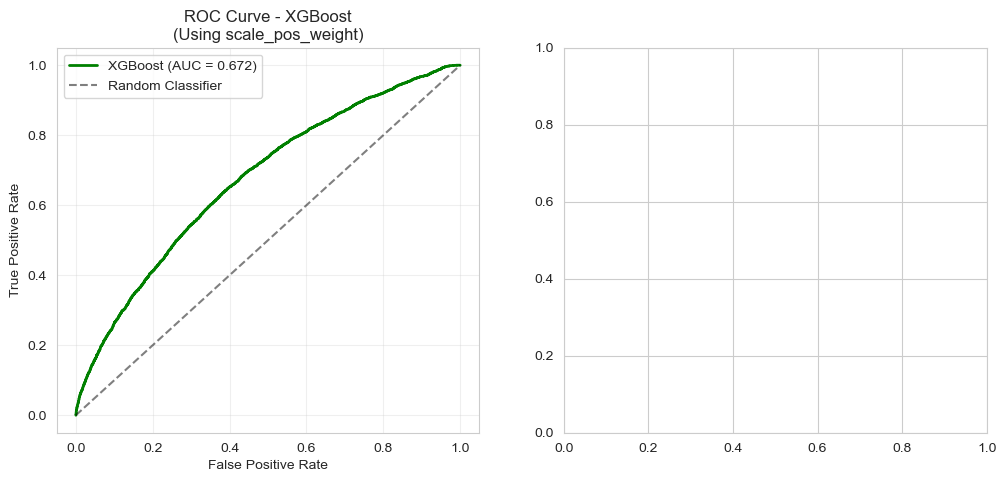

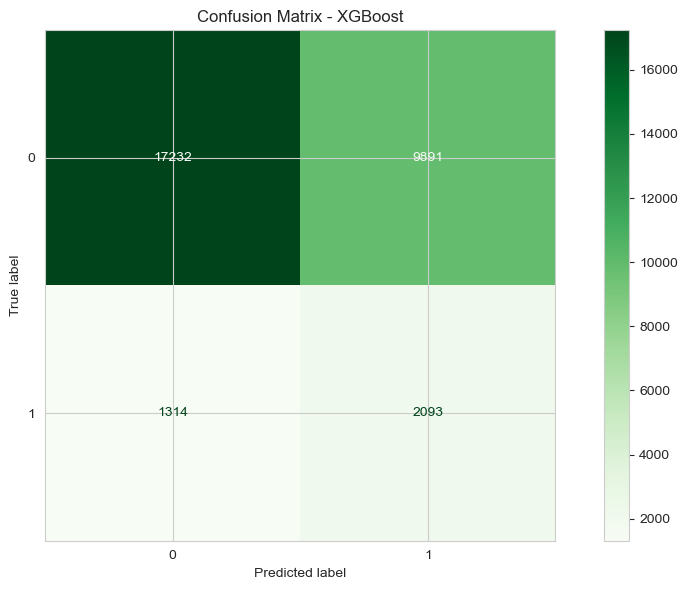

In [13]:
# Cell 5: XGBoost - Visualizations
# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr_xgb, tpr_xgb, color='green', linewidth=2, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost\n(Using scale_pos_weight)')
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion Matrix
plt.subplot(1, 2, 2)
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test, cmap='Greens')
plt.title('Confusion Matrix - XGBoost')

plt.tight_layout()
plt.show()

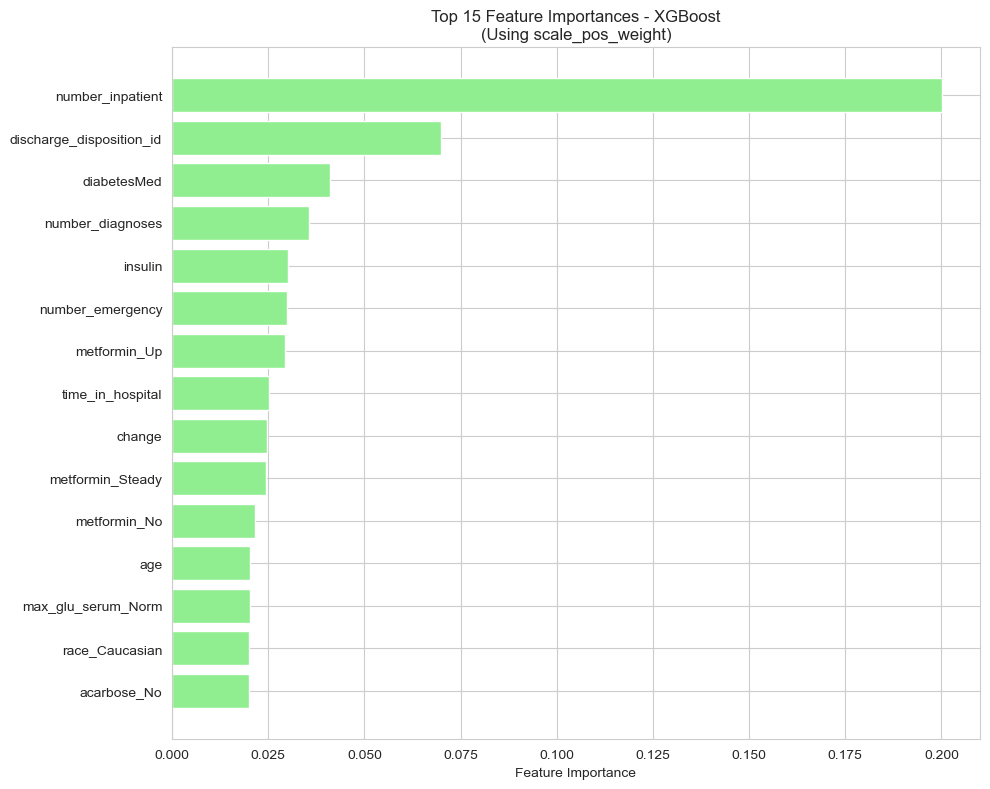

🔍 TOP 10 MOST IMPORTANT FEATURES:
 1. number_inpatient: 0.2000
 2. discharge_disposition_id: 0.0699
 3. diabetesMed: 0.0410
 4. number_diagnoses: 0.0357
 5. insulin: 0.0302
 6. number_emergency: 0.0299
 7. metformin_Up: 0.0294
 8. time_in_hospital: 0.0252
 9. change: 0.0246
10. metformin_Steady: 0.0245


In [15]:
# XGBoost - Feature Importance
feature_importance = best_xgb.feature_importances_
feature_names = X.columns

# Get top 15 features
indices = np.argsort(feature_importance)[-15:]
features_sorted = [feature_names[i] for i in indices]
importance_sorted = feature_importance[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(len(features_sorted)), importance_sorted, color='lightgreen')
plt.yticks(range(len(features_sorted)), features_sorted)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - XGBoost\n(Using scale_pos_weight)')
plt.tight_layout()
plt.show()

print("🔍 TOP 10 MOST IMPORTANT FEATURES:")
for i, (feature, imp) in enumerate(zip(features_sorted[-10:][::-1], importance_sorted[-10:][::-1])):
    print(f"{i+1:2d}. {feature}: {imp:.4f}")